In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

In [2]:
np.random.seed(12345)
r = 0.05
sigma = 0.5
T = 1
s0 = 100
K = 110
B = 90
N = 10000  # Number of simulations
M = 1000 # Number of time steps
dt = T / M

# simulate GBM paths
def simulate_gbm_paths(s0, r, sigma, T, M, N):
    paths = np.zeros((M + 1, N))
    paths[0] = s0
    for t in range(1, M + 1):
        Z = np.random.standard_normal(N)
        paths[t] = paths[t - 1] * np.exp((r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z)
    return paths

# Calculate the probability of not crossing the barrier
def survival_probability(X_i, X_j, B, h):
    return 1 - np.exp(-2 * (B - X_i) * (B - X_j) / (sigma**2 * h))

# Calculate the payoff with barrier
def barrier_option_payoff(paths, K, B, r, T):
    n = paths.shape[0] - 1
    h = T / n
    payoff = np.zeros(paths.shape[1])
    
    for j in range(paths.shape[1]):
        survival = 1
        for i in range(n):
            X_i = paths[i, j]
            X_j = paths[i + 1, j]
            if X_i < B or X_j < B:
                survival = 0
                break
            p_i = survival_probability(X_i, X_j, B, h)
            U_i = np.random.uniform(0, 1)
            if U_i > p_i:
                survival = 0
                break
        payoff[j] = np.exp(-r * T) * max(paths[-1, j] - K, 0) * survival
    
    return payoff

# Estimate Delta using pathwise sensitivity
def estimate_delta(paths, K, B, r, T):
    n = paths.shape[0] - 1
    h = T / n
    payoff = np.zeros(paths.shape[1])
    delta_sensitivity = np.zeros(paths.shape[1])
    
    for j in range(paths.shape[1]):
        survival = 1
        for i in range(n):
            X_i = paths[i, j]
            X_j = paths[i + 1, j]
            if X_i < B or X_j < B:
                survival = 0
                break
            p_i = survival_probability(X_i, X_j, B, h)
            U_i = np.random.uniform(0, 1)
            if U_i > p_i:
                survival = 0
                break
        payoff[j] = np.exp(-r * T) * max(paths[-1, j] - K, 0) * survival
        if paths[-1, j] > K:
            delta_sensitivity[j] = np.exp(-r * T) * (paths[-1, j] / s0) * survival
    
    delta = np.mean(delta_sensitivity)
    return delta

# Function to estimate Vega using pathwise sensitivity
def estimate_vega(paths, K, B, r, T):
    n = paths.shape[0] - 1
    h = T / n
    payoff = np.zeros(paths.shape[1])
    vega_sensitivity = np.zeros(paths.shape[1])
    
    for j in range(paths.shape[1]):
        survival = 1
        for i in range(n):
            X_i = paths[i, j]
            X_j = paths[i + 1, j]
            if X_i < B or X_j < B:
                survival = 0
                break
            p_i = survival_probability(X_i, X_j, B, h)
            U_i = np.random.uniform(0, 1)
            if U_i > p_i:
                survival = 0
                break
        payoff[j] = np.exp(-r * T) * max(paths[-1, j] - K, 0) * survival
        if paths[-1, j] > K:
            vega_sensitivity[j] = np.exp(-r * T) * (paths[-1, j] * ((np.log(paths[-1, j] / s0) - (r - 0.5 * sigma**2) * T) / sigma - sigma*T)) * survival
    
    vega = np.mean(vega_sensitivity)
    return vega

# Simulate paths
paths = simulate_gbm_paths(s0, r, sigma, T, M, N)
payoff = barrier_option_payoff(paths, K, B, r, T)
option_price = np.mean(payoff)
# Estimate Delta and Vega
delta = estimate_delta(paths, K, B, r, T)
vega = estimate_vega(paths, K, B, r, T)

print(f"Estimated Payoff: {option_price}")
print(f"Estimated Delta: {delta}")
print(f"Estimated Vega: {vega}")

Estimated Payoff: 8.612367156308522
Estimated Delta: 0.2315666505692444
Estimated Vega: 20.02563790425641


In [3]:
def running_mean(data):
    return np.cumsum(data) / np.arange(1, len(data) + 1)

Estimating price/greeks: 100%|██████████| 999/999 [26:18<00:00,  1.58s/it]


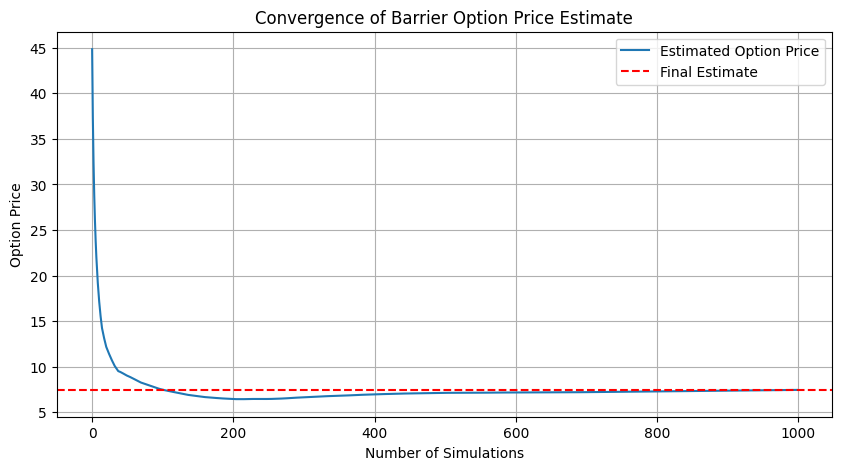

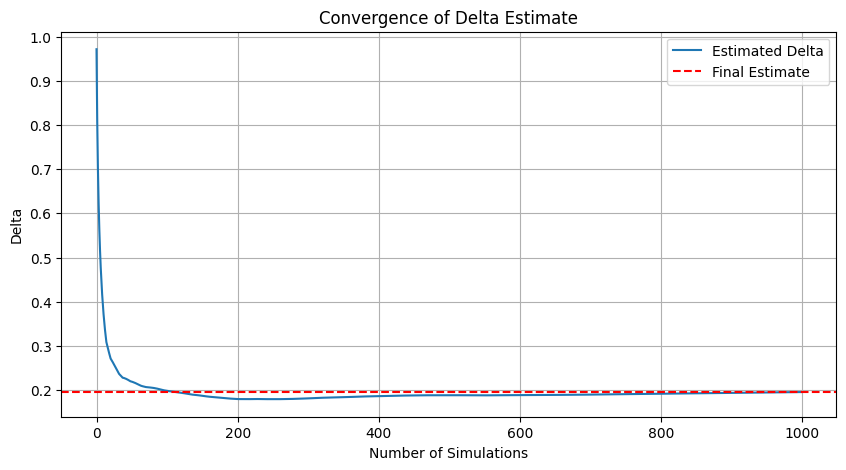

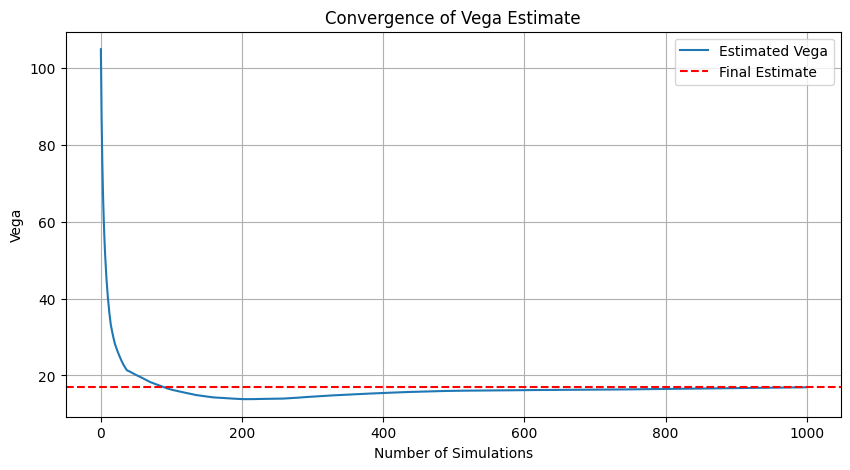

In [ ]:
from tqdm import tqdm

N_simulations = 1000  # Number of simulations to visualize convergence
paths = simulate_gbm_paths(s0, r, sigma, T, M, N_simulations)

# Initialize arrays
option_prices = []
deltas = []
vegas = []

# Add progress bar to simulation loop
for i in tqdm(range(1, N_simulations), desc="Estimating price/greeks"):
    current_paths = paths[:, :i+1]
    option_prices.append(np.mean(barrier_option_payoff(current_paths, K, B, r, T)))
    deltas.append(estimate_delta(current_paths, K, B, r, T))
    vegas.append(estimate_vega(current_paths, K, B, r, T))

# Convert to NumPy arrays
option_prices = np.array(option_prices)
deltas = np.array(deltas)
vegas = np.array(vegas)

# Running averages to smooth convergence curves
option_prices_running = running_mean(option_prices)
deltas_running = running_mean(deltas)
vegas_running = running_mean(vegas)



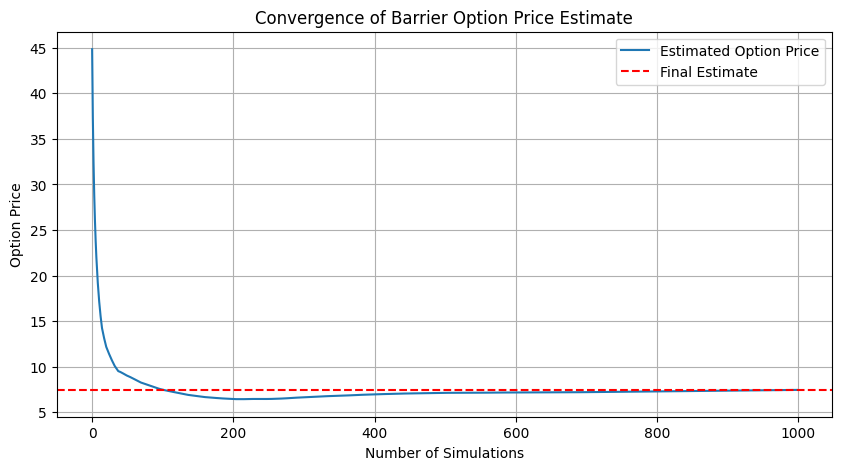

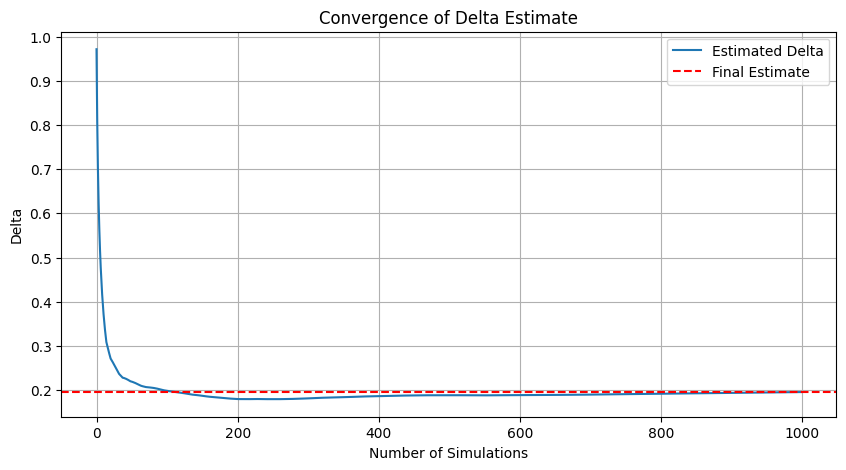

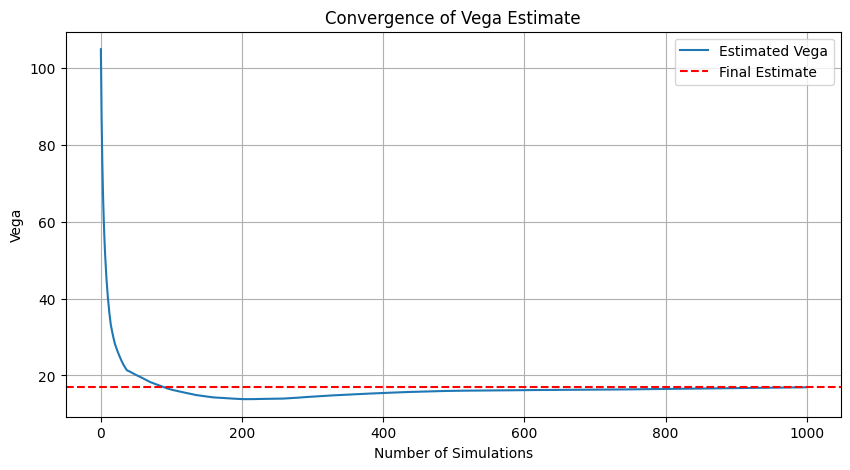

In [8]:
# Plot Convergence of Option Price
plt.figure(figsize=(10, 5))
plt.plot(option_prices_running, label="Estimated Option Price")
plt.axhline(y=np.mean(option_prices), color='r', linestyle='--', label="Final Estimate")
plt.xlabel("Number of Simulations")
plt.ylabel("Option Price")
plt.title("Convergence of Barrier Option Price Estimate")
plt.legend()
plt.grid()
plt.savefig("price_conv.pdf",format = 'pdf')
plt.show()

# Plot Convergence of Delta
plt.figure(figsize=(10, 5))
plt.plot(deltas_running, label="Estimated Delta")
plt.axhline(y=np.mean(deltas), color='r', linestyle='--', label="Final Estimate")
plt.xlabel("Number of Simulations")
plt.ylabel("Delta")
plt.title("Convergence of Delta Estimate")
plt.legend()
plt.grid()
plt.savefig("delta_conv.pdf",format = 'pdf')
plt.show()

# Plot Convergence of Vega
plt.figure(figsize=(10, 5))
plt.plot(vegas_running, label="Estimated Vega")
plt.axhline(y=np.mean(vegas), color='r', linestyle='--', label="Final Estimate")
plt.xlabel("Number of Simulations")
plt.ylabel("Vega")
plt.title("Convergence of Vega Estimate")
plt.legend()
plt.grid()
plt.savefig("vega_conv.pdf",format = 'pdf')
plt.show()

In [32]:
np.random.seed(12345)
M1_price_list = []
M2_price_list = []
M3_price_list = []

M1_delta_list = []
M2_delta_list = []
M3_delta_list = []

M1_vega_list = []
M2_vega_list = []
M3_vega_list = []

M_list = [1,4,10,15,30,60,80,105,120,150,185,225,250]
h = [T/i for i in M_list]
for i,M1 in enumerate(M_list):
    dt = T/M1
    paths1 = simulate_gbm_paths(s0, r, sigma, T, M1, N)
    price1 = np.mean(barrier_option_payoff(paths1, K, B, r, T))
    delta1 = estimate_delta(paths1, K, B, r, T)
    vega1 = estimate_vega(paths1, K, B, r, T)
    
    M1_price_list.append(price1)
    M1_delta_list.append(delta1)
    M1_vega_list.append(vega1)
    
    M2 = M1*2
    dt = T/M2
    paths2 = simulate_gbm_paths(s0, r, sigma, T, M2, N)
    price2 = np.mean(barrier_option_payoff(paths2, K, B, r, T))
    delta2 = estimate_delta(paths2, K, B, r, T)
    vega2 = estimate_vega(paths2, K, B, r, T)
    
    M2_price_list.append(price2)
    M2_delta_list.append(delta2)
    M2_vega_list.append(vega2)
    
    M3 = M1*4
    dt = T/M3
    paths3 = simulate_gbm_paths(s0, r, sigma, T, M3, N)
    price3 = np.mean(barrier_option_payoff(paths3, K, B, r, T))
    delta3 = estimate_delta(paths3, K, B, r, T)
    vega3 = estimate_vega(paths3, K, B, r, T)
    
    M3_price_list.append(price3)
    M3_delta_list.append(delta3)
    M3_vega_list.append(vega3)
    
    print(f"Trial {i+1:2d}: Price: h = {price1:.4f}, h/2 = {price2:.4f}, h/4 = {price3:.4f} | " +
          f"Delta: h = {delta1:.4f}, h/2 = {delta2:.4f}, h/4 = {delta3:.4f} | " +
          f"Vega: h = {vega1:.4f}, h/2 = {vega2:.4f}, h/4 = {vega3:.4f}")



Trial  1: Price: h = 17.5123, h/2 = 17.6297, h/4 = 15.6981 | Delta: h = 0.5586, h/2 = 0.5147, h/4 = 0.4418 | Vega: h = 37.7995, h/2 = 39.9410, h/4 = 36.0397
Trial  2: Price: h = 15.5210, h/2 = 13.9173, h/4 = 12.3948 | Delta: h = 0.4450, h/2 = 0.3854, h/4 = 0.3395 | Vega: h = 35.4520, h/2 = 32.1281, h/4 = 28.7735
Trial  3: Price: h = 13.8557, h/2 = 12.0054, h/4 = 11.4869 | Delta: h = 0.3780, h/2 = 0.3238, h/4 = 0.3014 | Vega: h = 32.3761, h/2 = 27.9442, h/4 = 27.2177
Trial  4: Price: h = 12.6116, h/2 = 10.8742, h/4 = 10.4791 | Delta: h = 0.3459, h/2 = 0.2997, h/4 = 0.2768 | Vega: h = 29.3145, h/2 = 25.1560, h/4 = 24.6290
Trial  5: Price: h = 11.2512, h/2 = 11.4775, h/4 = 10.0061 | Delta: h = 0.3018, h/2 = 0.2972, h/4 = 0.2672 | Vega: h = 26.2341, h/2 = 27.3048, h/4 = 23.3986
Trial  6: Price: h = 10.3631, h/2 = 9.9160, h/4 = 9.3303 | Delta: h = 0.2832, h/2 = 0.2635, h/4 = 0.2493 | Vega: h = 23.9967, h/2 = 23.2256, h/4 = 21.8064
Trial  7: Price: h = 10.1192, h/2 = 9.8747, h/4 = 8.9165 | D

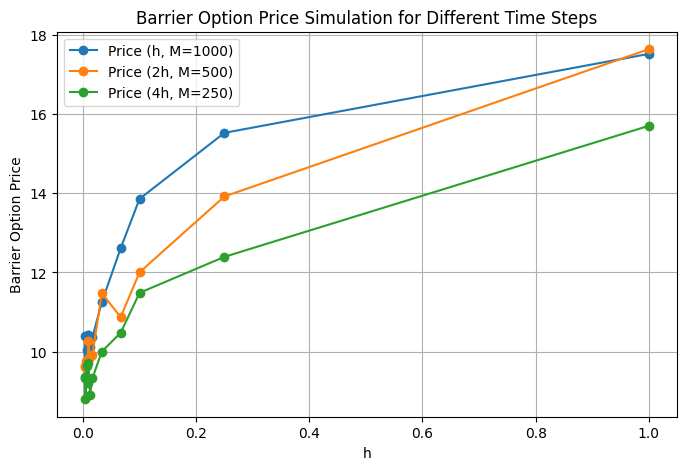

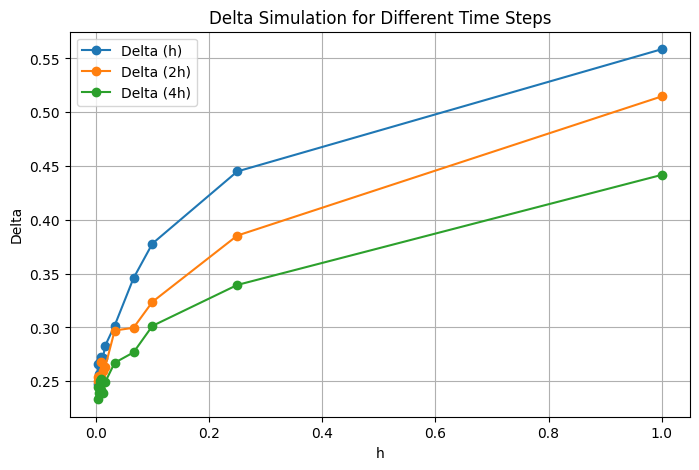

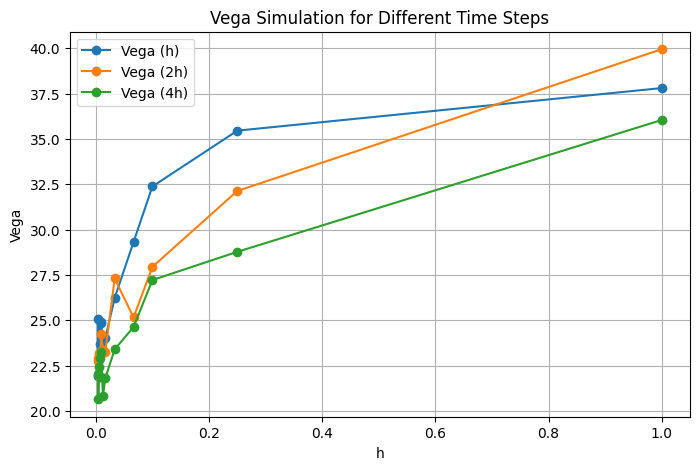

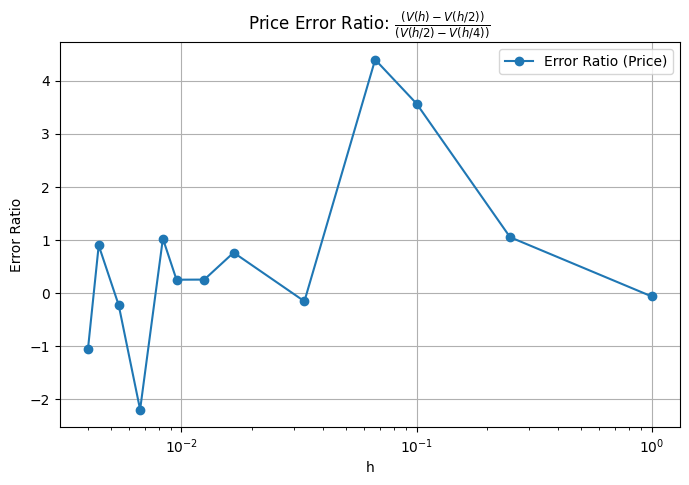

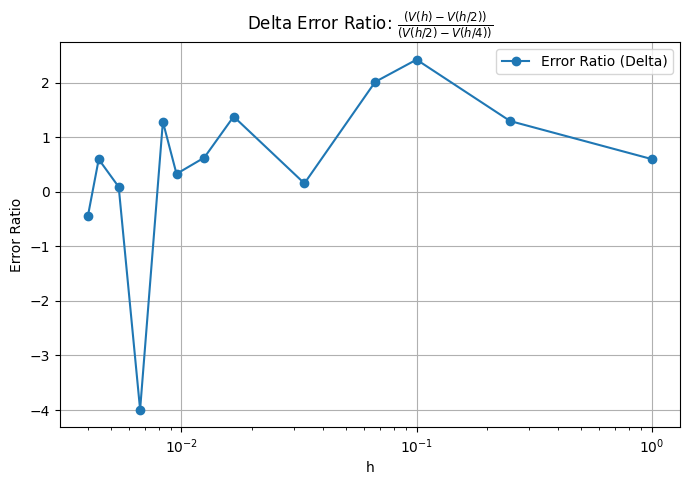

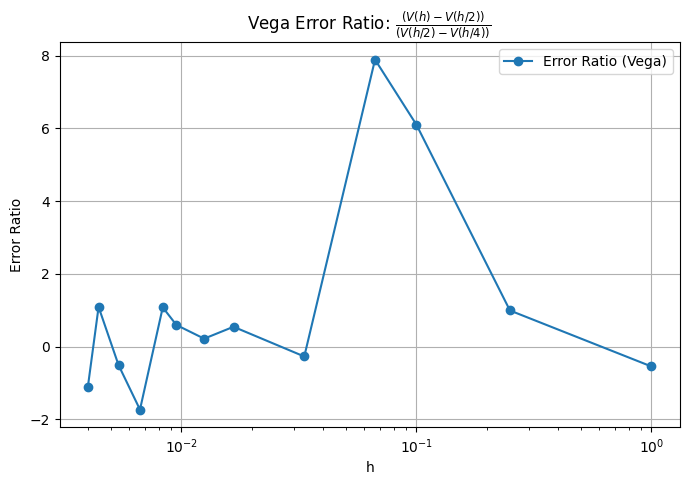

In [33]:
# Plot the option price for different time step sizes
plt.figure(figsize=(8,5))
plt.plot(h, M1_price_list, marker='o', linestyle='-', label="Price (h, M=1000)")
plt.plot(h, M2_price_list, marker='o', linestyle='-', label="Price (2h, M=500)")
plt.plot(h, M3_price_list, marker='o', linestyle='-', label="Price (4h, M=250)")
plt.xlabel("h")
plt.ylabel("Barrier Option Price")
plt.title("Barrier Option Price Simulation for Different Time Steps")
plt.legend()
plt.grid(True)
plt.show()

# Plot the Delta results
plt.figure(figsize=(8,5))
plt.plot(h, M1_delta_list, marker='o', linestyle='-', label="Delta (h)")
plt.plot(h, M2_delta_list, marker='o', linestyle='-', label="Delta (2h)")
plt.plot(h, M3_delta_list, marker='o', linestyle='-', label="Delta (4h)")
plt.xlabel("h")
plt.ylabel("Delta")
plt.title("Delta Simulation for Different Time Steps")
plt.legend()
plt.grid(True)
plt.show()

# Plot the Vega results
plt.figure(figsize=(8,5))
plt.plot(h, M1_vega_list, marker='o', linestyle='-', label="Vega (h)")
plt.plot(h, M2_vega_list, marker='o', linestyle='-', label="Vega (2h)")
plt.plot(h, M3_vega_list, marker='o', linestyle='-', label="Vega (4h)")
plt.xlabel("h")
plt.ylabel("Vega")
plt.title("Vega Simulation for Different Time Steps")
plt.legend()
plt.grid(True)
plt.show()

# Calculate the error ratios for price, Delta, and Vega 
# using the formula: (V(h) - V(2h)) / (V(2h) - V(4h))
error_ratio_price = []
error_ratio_delta = []
error_ratio_vega = []
for p1, p2, p3, d1, d2, d3, v1, v2, v3 in zip(M1_price_list, M2_price_list, M3_price_list,
                                                 M1_delta_list, M2_delta_list, M3_delta_list,
                                                 M1_vega_list, M2_vega_list, M3_vega_list):
    if np.abs(p2 - p3) > 1e-8:
        error_ratio_price.append((p1 - p2) / (p2 - p3))
    else:
        error_ratio_price.append(np.nan)
    if np.abs(d2 - d3) > 1e-8:
        error_ratio_delta.append((d1 - d2) / (d2 - d3))
    else:
        error_ratio_delta.append(np.nan)
    if np.abs(v2 - v3) > 1e-8:
        error_ratio_vega.append((v1 - v2) / (v2 - v3))
    else:
        error_ratio_vega.append(np.nan)
        
# Plot the price error ratio
plt.figure(figsize=(8,5))
plt.plot(h,error_ratio_price, marker='o', linestyle='-', label="Error Ratio (Price)")
plt.xscale('log')
plt.xlabel("h")
plt.ylabel("Error Ratio")
plt.title(r"Price Error Ratio: $\frac{(V(h)-V(h/2))}{(V(h/2)-V(h/4))}$")
plt.legend()
plt.grid(True)
plt.savefig("price_error.pdf",format = "pdf")
plt.show()

# Plot the Delta error ratio
plt.figure(figsize=(8,5))
plt.plot(h, error_ratio_delta, marker='o', linestyle='-', label="Error Ratio (Delta)")
plt.xscale('log')

plt.xlabel("h")
plt.ylabel("Error Ratio")
plt.title(r"Delta Error Ratio: $\frac{(V(h)-V(h/2))}{(V(h/2)-V(h/4))}$")
plt.legend()
plt.grid(True)
plt.savefig("delta_error.pdf",format = "pdf")

plt.show()

# Plot the Vega error ratio
plt.figure(figsize=(8,5))
plt.plot(h, error_ratio_vega, marker='o', linestyle='-', label="Error Ratio (Vega)")
plt.xscale('log')

plt.xlabel("h")
plt.ylabel("Error Ratio")
plt.title(r"Vega Error Ratio: $\frac{(V(h)-V(h/2))}{(V(h/2)-V(h/4))}$")
plt.legend()
plt.grid(True)
plt.savefig("vega_error.pdf",format = "pdf")

plt.show()


In [25]:
error_ratio_price

[np.float64(3.0888373931371054),
 np.float64(-0.3053750037936116),
 np.float64(0.8377147151914162),
 np.float64(2.927887969506226),
 np.float64(-0.00943214203334988),
 np.float64(-0.22979378126800978),
 np.float64(-0.6748173707387088),
 np.float64(-0.007727493981556844)]